In [107]:
from functools import cmp_to_key

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
# set matplotlib backend to inline
%matplotlib inline

# import modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.multiclass import unique_labels
from numpy import int64
from sklearn.utils import check_X_y, check_array
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.feature_selection import f_classif


In [108]:
def read_nhl_data():
    _nhl_data = pd.read_csv('moneypack/all_teams.csv')
    _nhl_data = _nhl_data.dropna()

    columns_to_drop = [
        'name', 'gameId', 'playerTeam',
        'opposingTeam', 'home_or_away',
        'gameDate', 'position',
        'situation', 'iceTime',
        #'playoffGame'
    ]

    _nhl_data = _nhl_data.sort_values(by=['team', 'season'])
    _nhl_data = _nhl_data.drop(columns=columns_to_drop)
    _nhl_data = _nhl_data.groupby(['team', 'season'], as_index=False).mean()
    _nhl_data['playoff_qualified'] = _nhl_data['playoffGame'].apply(lambda val: 1 if val > 0 else 0)
    _nhl_data = _nhl_data.drop(columns=['playoffGame'])

    return _nhl_data


def read_nhl_data_2023():
    _nhl_data_2023 = pd.read_csv('moneypack/teams_2023.csv')
    columns_to_drop_from_2023 = ['name', 'position', 'situation', 'iceTime', 'team.1', 'games_played']

    _nhl_data_2023 = _nhl_data_2023.dropna()
    _nhl_data_2023 = _nhl_data_2023.drop(columns=columns_to_drop_from_2023)
    _nhl_data_2023 = _nhl_data_2023.sort_values(by=['team', 'season'])
    _nhl_data_2023 = _nhl_data_2023.groupby(['team', 'season']).mean()
    return _nhl_data_2023


def get_team_names(_team_data):
    duplicates = pd.DataFrame(_team_data['team']).drop_duplicates(subset=None, keep='first', inplace=False,
                                                                  ignore_index=False)
    duplicates = duplicates.sort_values(by=['team'])
    return duplicates['team'].values

In [109]:
by_team_season_all = read_nhl_data()
by_team_season_all = by_team_season_all[(by_team_season_all['season'] != 2023)]
by_team_season_all = by_team_season_all[(by_team_season_all['season'] != 2022)]

seasons_data_all = by_team_season_all.drop(columns=['playoff_qualified', 'season', 'team'])
seasons_target_all = by_team_season_all['playoff_qualified'].values

In [110]:
by_team_season_all = read_nhl_data()
by_team_season_all = by_team_season_all[(by_team_season_all['season'] == 2022)]

seasons_teams_2022 = get_team_names(by_team_season_all)
seasons_data_2022 = by_team_season_all.drop(columns=['playoff_qualified', 'season', 'team'])
seasons_target_2022 = by_team_season_all['playoff_qualified'].values

In [111]:
seasons_data_2023 = read_nhl_data_2023()
seasons_teams_2023 = get_team_names(pd.read_csv('moneypack/teams_2023.csv'))
seasons_target_2023 = [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
                       0]  #<40

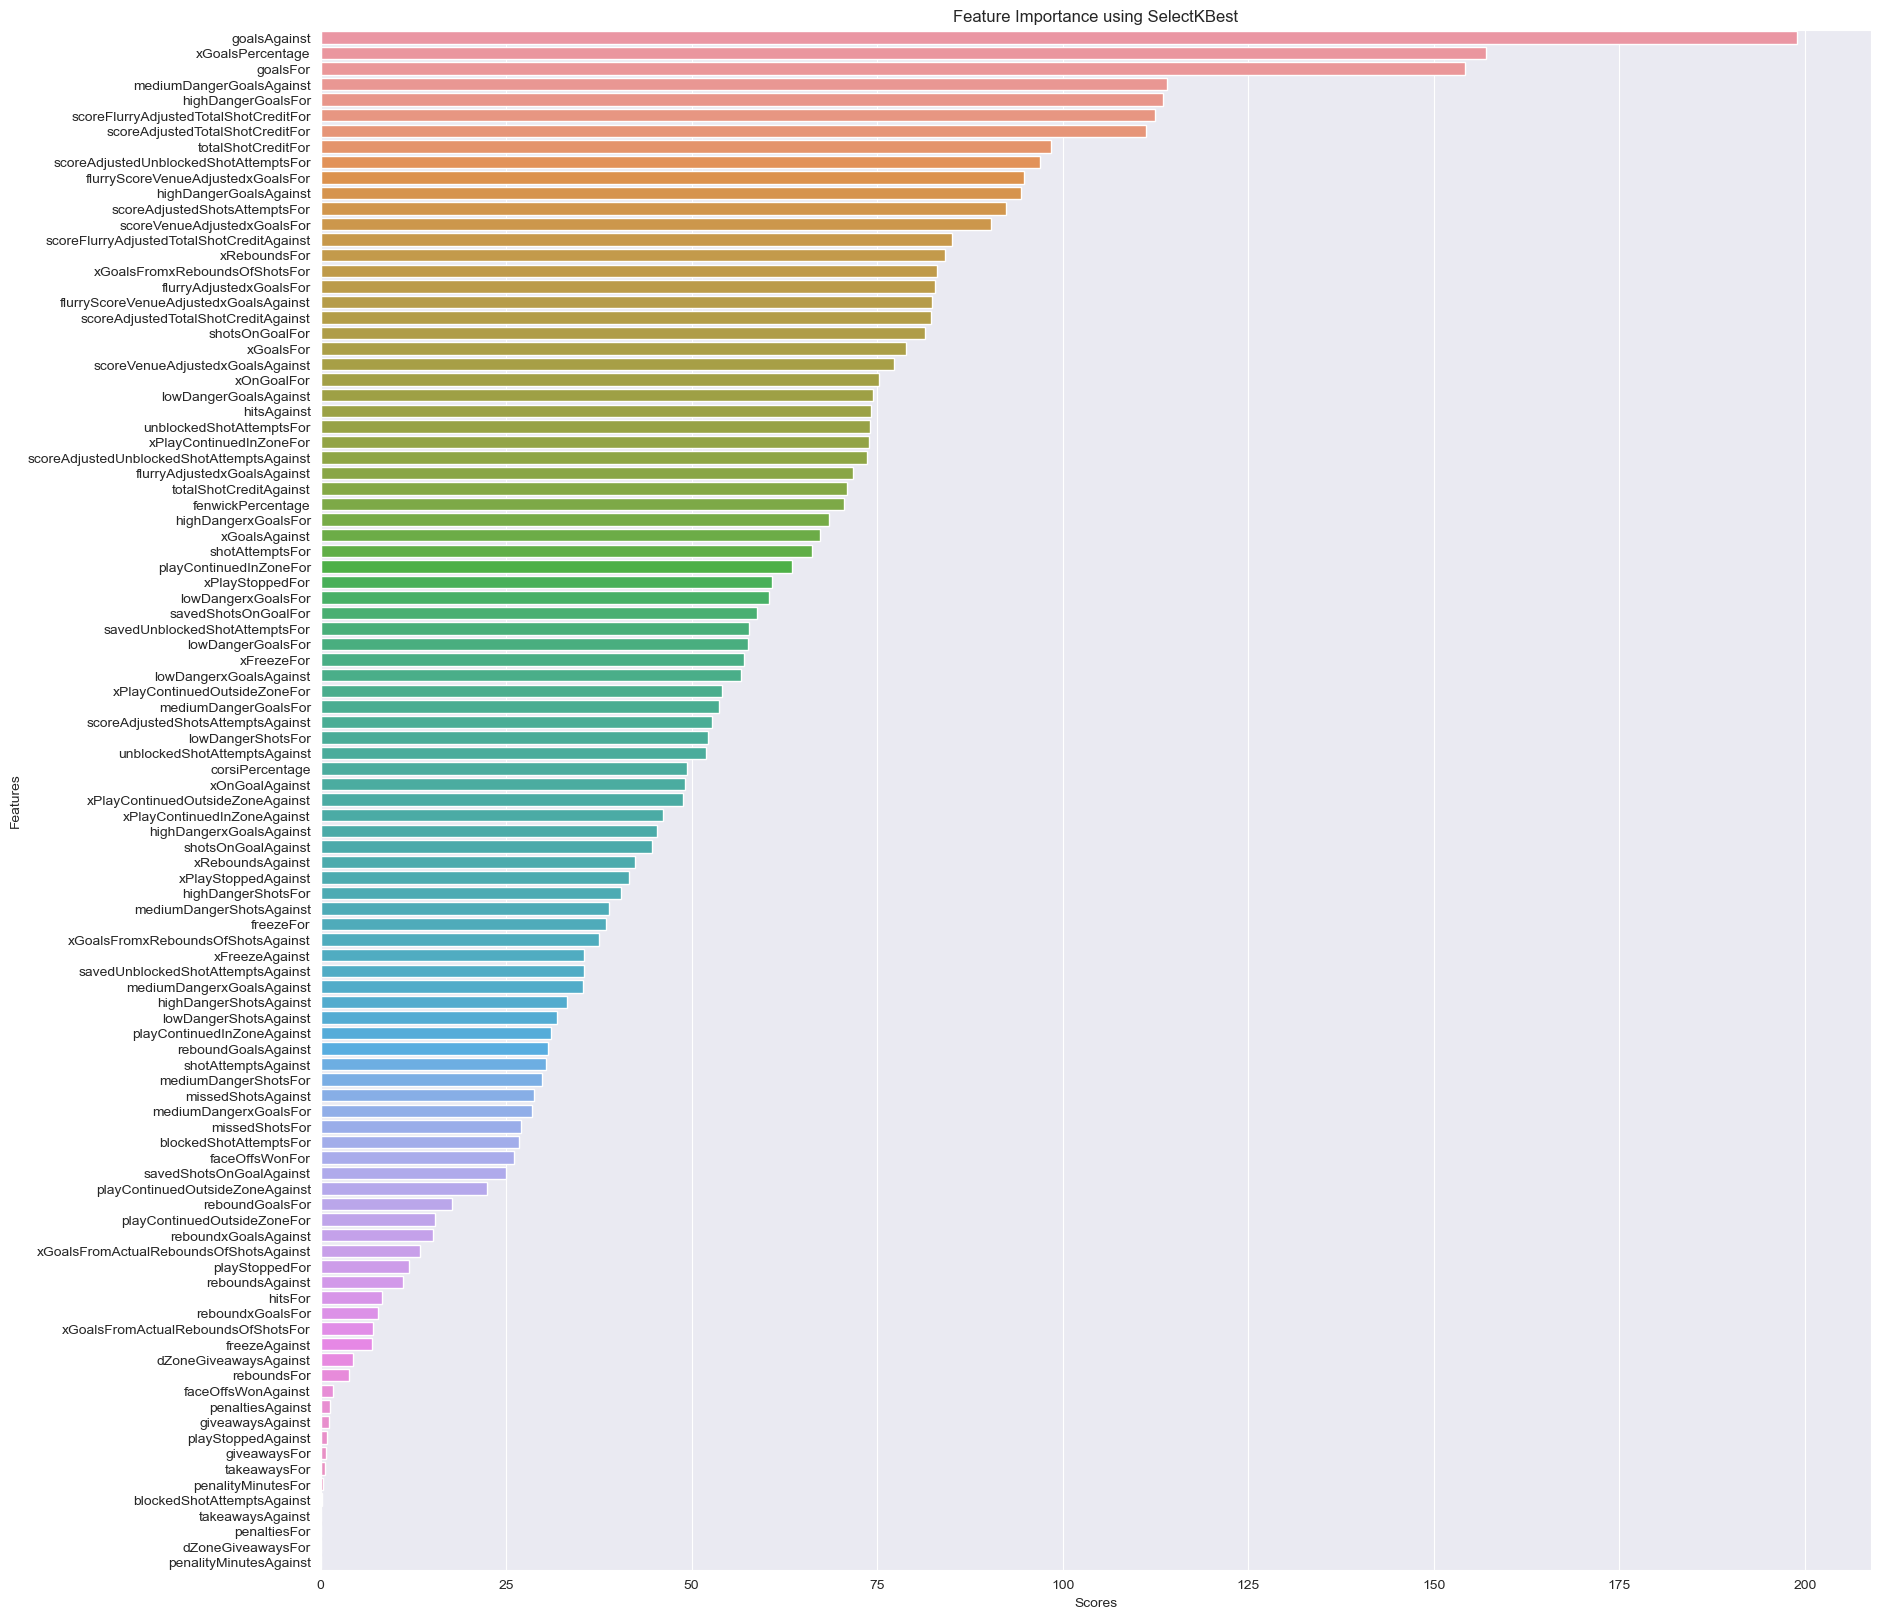

In [112]:

best_features = SelectKBest(score_func=f_classif, k=5).fit(seasons_data_all.values, seasons_target_all)
selected_features = seasons_data_all.columns[best_features.get_support()]
sorted_index = np.argsort(best_features.scores_)[::-1]
sorted_scores = best_features.scores_[sorted_index]
sorted_feature_names = np.array(seasons_data_all.columns)[sorted_index]
sorted_features_all = pd.DataFrame({"feature": sorted_feature_names, "score": sorted_scores})

plt.figure(figsize=(20, 20))
sns.barplot(x=sorted_scores, y=sorted_feature_names)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importance using SelectKBest')
plt.show()


In [113]:
sorted_features_all = sorted_features_all[sorted_features_all['score'] > 100]
sorted_features_all_names = sorted_features_all['feature'].values

scaler = StandardScaler()
seasons_data_all_features = scaler.fit_transform(seasons_data_all[sorted_features_all_names])
seasons_data_2022_features = scaler.fit_transform(seasons_data_2022[sorted_features_all_names])
seasons_data_2023_features = scaler.fit_transform(seasons_data_2023[sorted_features_all_names])


In [114]:
class MyKNearestNeighborsClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, k_neighbors):
        self.classes_ = None
        self.k_neighbors = k_neighbors
        self._k = None
        self._x = None
        self._y = None

    def get_params(self, deep=True):
        return {"k_neighbors": self.k_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, x, y):
        x, y = check_X_y(x, y)
        self.classes_ = unique_labels(y)
        self._k = self.__validate_k(self.k_neighbors)
        self._x = x
        self._y = y
        return self

    def predict(self, x_test):
        x_test = check_array(x_test)
        predicted_points = []
        for test_x_point in x_test:
            predicted_points.append(self.__predict_class(test_x_point))
        return np.array(predicted_points)

    def __predict_class(self, x_point):
        distances = []
        # calculate distances to all the training points
        for x_train_point in self._x:
            distances.append(self.__euclidean(x_train_point, x_point))

        nearest_indexes = np.argsort(distances)[:self._k]  # sort distances, take k nearest points' indices
        nearest_classes = self._y[nearest_indexes]  # take their classes
        # count number of occurrences of a class and return the index of max counter.

        # astype = nearest_classes.astype(int64)
        return np.bincount(nearest_classes).argmax()

    def __euclidean(self, point1, point2):
        distance = np.sum(np.square(point1 - point2))
        return np.sqrt(distance)

    def __validate_k(self, k):
        if k <= 0:
            raise Exception("K cannot be less or equal to zero")

        k += 1  # Ties can be broken consistently by expanding K by 1
        return k

# check_estimator(MyKNearestNeighborsClassifier(3))

In [115]:
from sklearn.model_selection import LearningCurveDisplay

def plot_learning_curve(estimator, x_data, y_data):
    common_params = {
        "X": x_data,
        "y": y_data,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=0),
        "score_type": "both",
        "n_jobs": 4,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "Accuracy",
    }
    
    LearningCurveDisplay.from_estimator(estimator, **common_params)
    
def plot_learning_curve1(estimator, x_data, y_data):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, x_data, y_data, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy', shuffle=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Accuracy")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()


def run_cross_validation(classifier_instance, _data, _target, _cv, scoring='neg_root_mean_squared_error'):
    _cv_results = cross_validate(classifier_instance,
                                 _data, _target,
                                 cv=_cv, scoring=scoring,
                                 return_estimator=True)
    _cv_results["test_error"] = -_cv_results["test_score"]
    return _cv_results


def run_prediction(_cv_result, _class, _data, _target, _data_for_prediction, _expected_result=None):
    plot_learning_curve(_class, _data, _target)
    _y_pred = _class.predict(_data_for_prediction)

    if _expected_result is not None:
        _precision = precision_score(_expected_result, _y_pred, average=None)
        _recall = recall_score(_expected_result, _y_pred, average=None)
        _accuracy = accuracy_score(_expected_result, _y_pred)
        _confusion_matrix = confusion_matrix(_expected_result, _y_pred)
        _f1_score = f1_score(_expected_result, _y_pred)
        _testing_error = mean_absolute_error(_expected_result, _y_pred)
        print(
            f'|{"Classifier":>45}|{"f1":>20}|{"accuracy":>20}|{"precision":>24}|{"recall":>23}|{"test error":>20}|')
        print(
            f'|{_class.__str__()[:40]:>45}|{_f1_score:>20}|{_accuracy:>20}|{_precision.__str__():>24}|{_recall.__str__():>23}|{_testing_error:>20}|')
    return _y_pred


def print_prediction(_teams, _pred, _season, _expected=None):
    _pred_table = pd.DataFrame({"team": _teams, "playoff qualified": _pred})
    if _expected is not None:
        _pred_table['expected'] = _expected
    print(f'\nPrediction for season {_season}\n{_pred_table}\n')



In [116]:

cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
data = seasons_data_all_features
target = seasons_target_all

n_neighbors = 5
max_depth = 5

classifier_knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
classifier_knn_my = MyKNearestNeighborsClassifier(n_neighbors)
classifier_dec_tree = DecisionTreeClassifier(max_depth=max_depth)
voting_clf_hard = VotingClassifier(estimators=[('knn', classifier_knn), ('decision_tree', classifier_dec_tree)],
                                   voting='hard')
voting_clf_soft = VotingClassifier(estimators=[('knn', classifier_knn), ('decision_tree', classifier_dec_tree)],
                                   voting='soft')

cv_results_knn = run_cross_validation(classifier_knn, data, target, cv)
best_knn = cv_results_knn["estimator"][0]

cv_results_knn_my = run_cross_validation(classifier_knn_my, data, target, cv)
best_knn_my = cv_results_knn_my["estimator"][0]

cv_results_dec_tree = run_cross_validation(classifier_dec_tree, data, target, cv)
best_dec_tree = cv_results_dec_tree["estimator"][0]

cv_results_hard = run_cross_validation(voting_clf_hard, data, target, cv)
best_hard = cv_results_hard["estimator"][0]

cv_results_soft = run_cross_validation(voting_clf_soft, data, target, cv)
best_soft = cv_results_soft["estimator"][0]



In [117]:
def predict_and_print(_results, _classifier, _data, _target, _features, _expected, _season, _teams):
    _pred_results = run_prediction(_results, _classifier,
                                   _data, _target,
                                   _features, _expected)
    print_prediction(_teams, _pred_results, _season, _expected)

|                                   Classifier|                  f1|            accuracy|               precision|                 recall|          test error|
|     KNeighborsClassifier(metric='euclidean')|   0.888888888888889|               0.875|               [1.  0.8]|            [0.75 1.  ]|               0.125|

Prediction for season 2022
   team  playoff qualified  expected
0   ANA                  0         0
1   ARI                  0         0
2   BOS                  1         1
3   BUF                  1         0
4   CAR                  1         1
5   CBJ                  0         0
6   CGY                  1         0
7   CHI                  0         0
8   COL                  1         1
9   DAL                  1         1
10  DET                  0         0
11  EDM                  1         1
12  FLA                  1         1
13  LAK                  1         1
14  MIN                  1         1
15  MTL                  0         0
16  NJD                

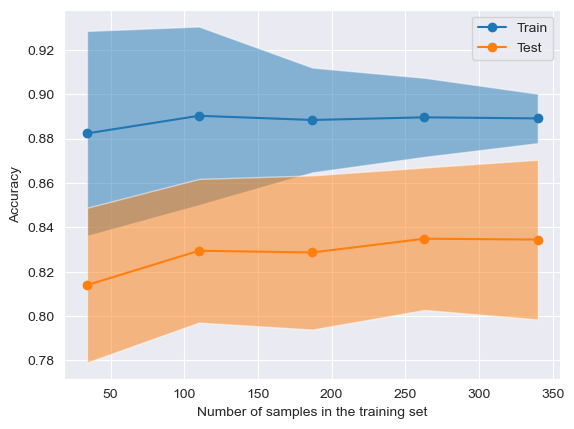

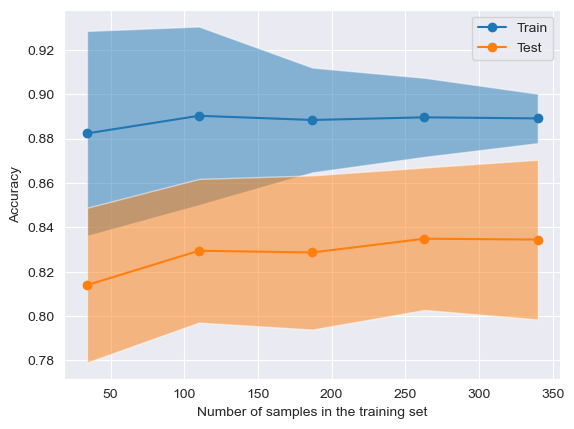

In [118]:
predict_and_print(cv_results_knn, best_knn, data, target, seasons_data_2022_features, seasons_target_2022, 2022, seasons_teams_2022)
predict_and_print(cv_results_knn, best_knn, data, target, seasons_data_2023_features, seasons_target_2023, 2023, seasons_teams_2023)


|                                   Classifier|                  f1|            accuracy|               precision|                 recall|          test error|
| MyKNearestNeighborsClassifier(k_neighbors=5)|   0.888888888888889|               0.875|               [1.  0.8]|            [0.75 1.  ]|               0.125|

Prediction for season 2022
   team  playoff qualified  expected
0   ANA                  0         0
1   ARI                  0         0
2   BOS                  1         1
3   BUF                  1         0
4   CAR                  1         1
5   CBJ                  0         0
6   CGY                  1         0
7   CHI                  0         0
8   COL                  1         1
9   DAL                  1         1
10  DET                  0         0
11  EDM                  1         1
12  FLA                  1         1
13  LAK                  1         1
14  MIN                  1         1
15  MTL                  0         0
16  NJD                

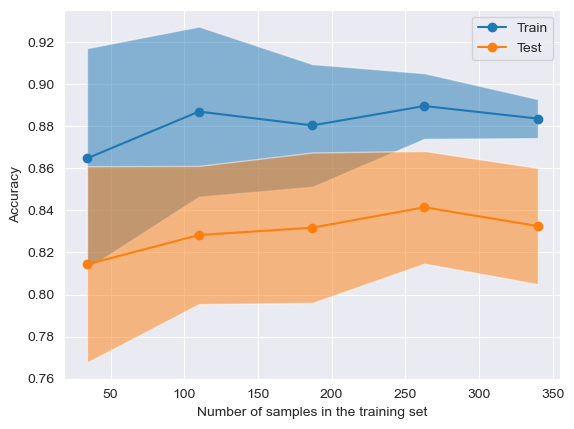

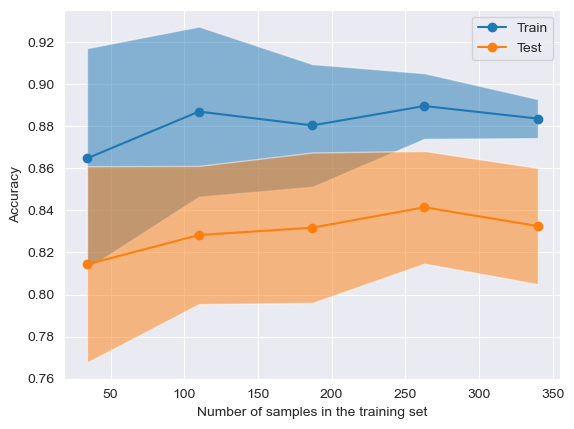

In [119]:
predict_and_print(cv_results_knn_my, best_knn_my, data, target, seasons_data_2022_features, seasons_target_2022, 2022, seasons_teams_2022)
predict_and_print(cv_results_knn_my, best_knn_my, data, target, seasons_data_2023_features, seasons_target_2023, 2023, seasons_teams_2023)

|                                   Classifier|                  f1|            accuracy|               precision|                 recall|          test error|
|          DecisionTreeClassifier(max_depth=5)|  0.8648648648648648|             0.84375| [1.         0.76190476]|        [0.6875 1.    ]|             0.15625|

Prediction for season 2022
   team  playoff qualified  expected
0   ANA                  0         0
1   ARI                  0         0
2   BOS                  1         1
3   BUF                  1         0
4   CAR                  1         1
5   CBJ                  0         0
6   CGY                  1         0
7   CHI                  0         0
8   COL                  1         1
9   DAL                  1         1
10  DET                  0         0
11  EDM                  1         1
12  FLA                  1         1
13  LAK                  1         1
14  MIN                  1         1
15  MTL                  0         0
16  NJD                

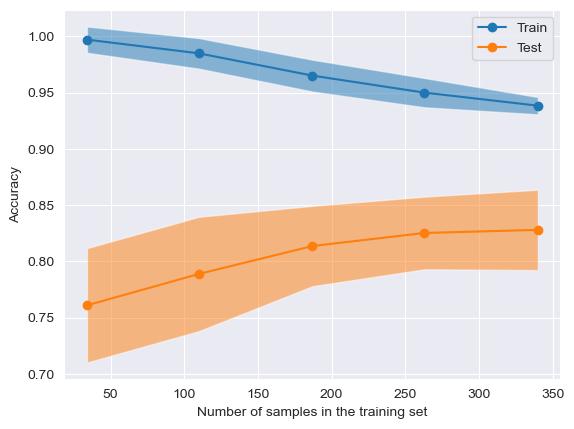

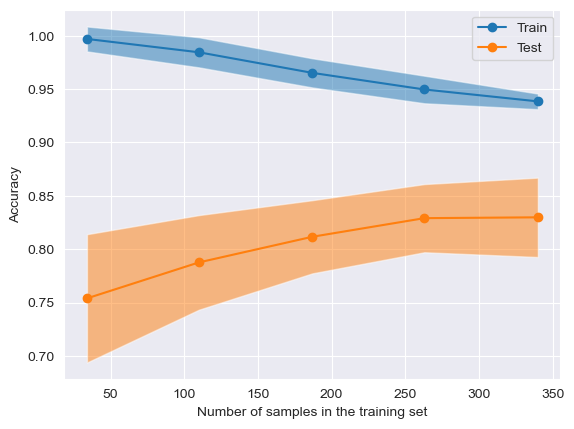

In [120]:
predict_and_print(cv_results_dec_tree, best_dec_tree, data, target, seasons_data_2022_features, seasons_target_2022, 2022, seasons_teams_2022)
predict_and_print(cv_results_dec_tree, best_dec_tree, data, target, seasons_data_2023_features, seasons_target_2023, 2023, seasons_teams_2023)

|                                   Classifier|                  f1|            accuracy|               precision|                 recall|          test error|
|VotingClassifier(estimators=[('knn', KNeighborsClassifier(metric='euclidean')),
                             ('decision_tree',
                              DecisionTreeClassifier(max_depth=5))])|  0.8823529411764706|               0.875| [0.92857143 0.83333333]|        [0.8125 0.9375]|               0.125|

Prediction for season 2022
   team  playoff qualified  expected
0   ANA                  0         0
1   ARI                  0         0
2   BOS                  1         1
3   BUF                  1         0
4   CAR                  1         1
5   CBJ                  0         0
6   CGY                  1         0
7   CHI                  0         0
8   COL                  1         1
9   DAL                  1         1
10  DET                  0         0
11  EDM                  1         1
12  FLA              

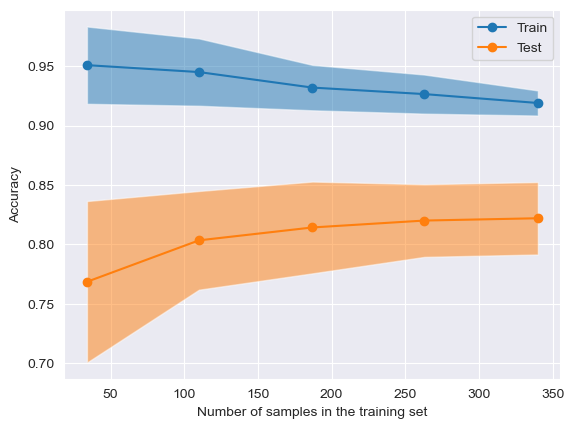

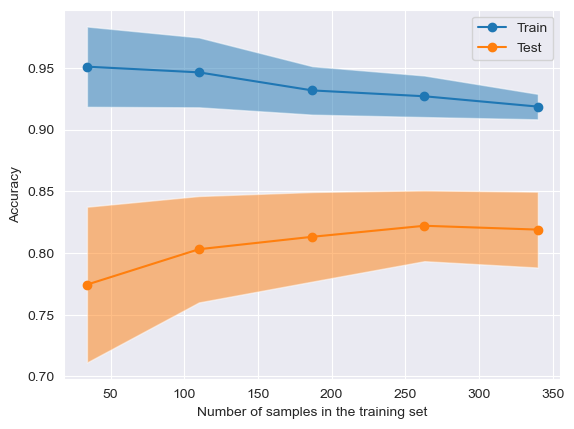

In [121]:
predict_and_print(cv_results_hard, best_hard, data, target, seasons_data_2022_features, seasons_target_2022, 2022, seasons_teams_2022)
predict_and_print(cv_results_hard, best_hard, data, target, seasons_data_2023_features, seasons_target_2023, 2023, seasons_teams_2023)

|                                   Classifier|                  f1|            accuracy|               precision|                 recall|          test error|
|VotingClassifier(estimators=[('knn', KNeighborsClassifier(metric='euclidean')),
                             ('decision_tree',
                              DecisionTreeClassifier(max_depth=5))],
                 voting='soft')|  0.8333333333333334|              0.8125| [0.91666667 0.75      ]|        [0.6875 0.9375]|              0.1875|

Prediction for season 2022
   team  playoff qualified  expected
0   ANA                  0         0
1   ARI                  0         0
2   BOS                  1         1
3   BUF                  1         0
4   CAR                  1         1
5   CBJ                  0         0
6   CGY                  1         0
7   CHI                  0         0
8   COL                  1         1
9   DAL                  1         1
10  DET                  0         0
11  EDM                  1

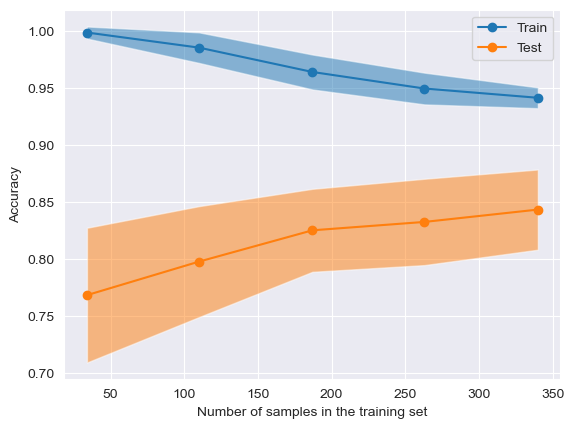

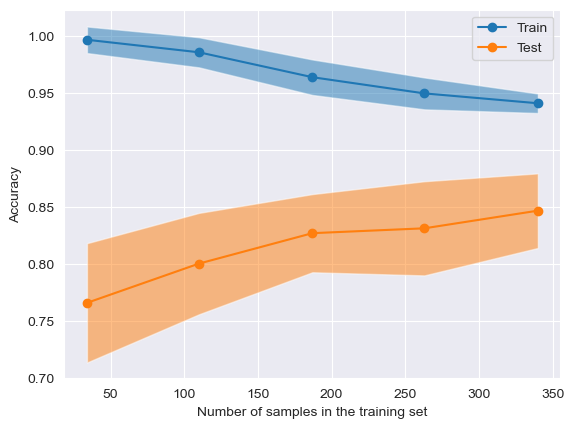

In [122]:
predict_and_print(cv_results_soft, best_soft, data, target, seasons_data_2022_features, seasons_target_2022, 2022, seasons_teams_2022)
predict_and_print(cv_results_soft, best_soft, data, target, seasons_data_2023_features, seasons_target_2023, 2023, seasons_teams_2023)